# BERT


In [1]:
import pandas as pd
import re
import numpy as np
from datasets import Dataset   # Hugginf Face Transformers & Datasets
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from sklearn.metrics import classification_report, confusion_matrix # For evaluation metrics

# 1) Load and clean dataset
df = pd.read_csv("Data/fake reviews dataset.csv")
df.rename(columns={'text_': 'text'}, inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text.strip()

df['cleaned_text'] = df['text'].apply(clean_text)
df['label'] = df['label'].map({'CG': 1, 'OR': 0})  # 1 = fake, 0 = real
df = df[['cleaned_text', 'label']]

# 2) HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df)
hf_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)

# 3) Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example["cleaned_text"], padding="max_length", truncation=True, max_length=128)
# Apply tokenizer to entire dataset
tokenized_dataset = hf_dataset.map(tokenize, batched=True)

# 4) Load DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# 5) Legacy-compatible TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,                  # Enable training
    do_eval=True,                   # Enable evaluation during training
    per_device_train_batch_size=8,  # Training batch size
    per_device_eval_batch_size=8,   # Eval batch size
    num_train_epochs=2,             # Train for 2 epochs
    logging_dir="./logs"            # Diretory to save logs
)

# 6) Data collator will pad input sequences during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Create trainer (handles training, evaluation, and saving)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# 7) Train the model
trainer.train()

# 8) Evaluate
predictions = trainer.predict(tokenized_dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
# Print performance & confusion matrix
print("\n=== Test Set Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["Real (OR)", "Fake (CG)"]))
print("=== Test Set Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 8087/8087 [00:00<00:00, 18589.03 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\AppData\Local\Temp\ipykernel_5488\3157348625.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.339900
1000,0.220100
1500,0.166200
2000,0.157900
2500,0.154000
3000,0.143000
3500,0.131800
4000,0.098200
4500,0.057700
5000,0.057500



=== Test Set Classification Report ===
              precision    recall  f1-score   support

   Real (OR)       0.98      0.97      0.97      4027
   Fake (CG)       0.97      0.98      0.97      4060

    accuracy                           0.97      8087
   macro avg       0.97      0.97      0.97      8087
weighted avg       0.97      0.97      0.97      8087

=== Test Set Confusion Matrix ===
[[3892  135]
 [  83 3977]]


Why DistilBERT Performs Better
-Context-aware embedding: Unlike TF-IDF or GloVe, BERT-based models understand the context of words in a sentence. 
-Pretrained on massive data: DistilBERT was trained on billions of tokens-enabling to generalize better to fake vs. real sentiment patterns
-Fine-tuned end-to-end: The classifier is trained with gradient updates through the entire transformer, not just on top of static featrues

In [2]:
# Load & Inspect Google Maps Reviews

# 1) Load the Google Maps restaurant reviews
df_google = pd.read_csv("Data/reviews.csv")

# 2) Display basic info
print("*** Dataset Info ***")
print(df_google.info())

# 3) Show sample rows
print("\n*** Sample Reviews ***")
print(df_google[['business_name', 'author_name', 'text', 'rating']].head())

# 4) Check for missing values
print("\n*** Missing Values ***")
print(df_google.isnull().sum())

# 5) Basic rating distribution
print("\n*** Rating Distribution ***")
print(df_google['rating'].value_counts().sort_index())





*** Dataset Info ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
dtypes: int64(1), object(5)
memory usage: 51.7+ KB
None

*** Sample Reviews ***
                     business_name    author_name  \
0  Haci'nin Yeri - Yigit Lokantasi    Gulsum Akar   
1  Haci'nin Yeri - Yigit Lokantasi  Oguzhan Cetin   
2  Haci'nin Yeri - Yigit Lokantasi     Yasin Kuyu   
3  Haci'nin Yeri - Yigit Lokantasi     Orhan Kapu   
4  Haci'nin Yeri - Yigit Lokantasi     Ozgur Sati   

                                                text  rating  
0  We went to Marmaris with my wife for a holiday..

In [3]:
# Clean & Tokenize Google Maps Reviews for Prediction
# 1) Load Google Maps reviews CSV
google_df = pd.read_csv("Data/reviews.csv")

# 2) Drop rows with missing review text (just in case)
google_df.dropna(subset=['text'], inplace=True)

# 3) Clean the text (same as before)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text.strip()

google_df['cleaned_text'] = google_df['text'].apply(clean_text)

# 4) Convert to HuggingFace Dataset format
google_hf_dataset = Dataset.from_pandas(google_df)

# 5) Tokenize using the same tokenizer as before
def tokenize_for_prediction(example):
    return tokenizer(example["cleaned_text"], padding="max_length", truncation=True, max_length=128)

tokenized_google_dataset = google_hf_dataset.map(tokenize_for_prediction, batched=True)

Map: 100%|██████████| 1100/1100 [00:00<00:00, 23847.41 examples/s]


In [5]:
import torch

# Predict Fake Reviews with DistilBERT

# 1) Load fine-tuned DistilBERT model and tokenizer
model_path = "./results/checkpoint-8088"  # Use the correct checkpoint
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()

# 2) Load and clean the Google Maps review dataset
df_google = pd.read_csv("Data/reviews.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text.strip()

df_google['cleaned_text'] = df_google['text'].apply(clean_text)

# 3) Tokenize cleaned text
tokens = tokenizer(
    list(df_google['cleaned_text']),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# 4) Predict in batches
BATCH_SIZE = 32
predictions = []

with torch.no_grad():
    for i in range(0, len(df_google), BATCH_SIZE):
        input_batch = {k: v[i:i+BATCH_SIZE] for k, v in tokens.items()}
        outputs = model(**input_batch)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        predictions.extend(preds.tolist())

# 5) Add predictions to DataFrame
df_google['predicted_label'] = predictions
df_google['predicted_fake'] = df_google['predicted_label'].map({1: True, 0: False})

# 6) Show preview
print("\n=== Predicted Review Types ===")
print(df_google[['business_name', 'text', 'rating', 'predicted_fake']].head())

# 7) Save to new CSV
df_google.to_csv("Data/reviews_with_predictions.csv", index=False)
print("\n Saved to 'Data/reviews_with_predictions.csv'")



=== Predicted Review Types ===
                     business_name  \
0  Haci'nin Yeri - Yigit Lokantasi   
1  Haci'nin Yeri - Yigit Lokantasi   
2  Haci'nin Yeri - Yigit Lokantasi   
3  Haci'nin Yeri - Yigit Lokantasi   
4  Haci'nin Yeri - Yigit Lokantasi   

                                                text  rating  predicted_fake  
0  We went to Marmaris with my wife for a holiday...       5           False  
1  During my holiday in Marmaris we ate here to f...       4           False  
2  Prices are very affordable. The menu in the ph...       3           False  
3  Turkey's cheapest artisan restaurant and its f...       5            True  
4  I don't know what you will look for in terms o...       3           False  

 Saved to 'Data/reviews_with_predictions.csv'


In [6]:
import pandas as pd
from scipy.stats import zscore

# Load the original predictions file
df = pd.read_csv("Data/reviews_with_predictions.csv")

# Compute original average rating per restaurant
original = df.groupby('business_name')['rating'].mean().reset_index()
original.columns = ['business_name', 'original_rating']
df = df.merge(original, on='business_name', how='left')

# Create a copy excluding predicted fake reviews
df_filtered = df[df['predicted_fake'] == False].copy()

# Z-score flag
def flag_zscore_outliers(group):
    if len(group) < 3:
        group['z_score_flagged'] = False
    else:
        z_scores = zscore(group['rating'])
        group['z_score_flagged'] = abs(z_scores) > 2.0
    return group

df_filtered = df_filtered.groupby('business_name', group_keys=False).apply(flag_zscore_outliers)

# IQR flag
def flag_iqr_outliers(group):
    if len(group) < 3:
        group['iqr_flagged'] = False
    else:
        q1 = group['rating'].quantile(0.25)
        q3 = group['rating'].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        group['iqr_flagged'] = ~group['rating'].between(lower, upper)
    return group

df_filtered = df_filtered.groupby('business_name', group_keys=False).apply(flag_iqr_outliers)
df_filtered['extreme_review'] = df_filtered['z_score_flagged'] | df_filtered['iqr_flagged']

# Compute adjusted rating
adjusted = df_filtered[df_filtered['extreme_review'] == False] \
    .groupby('business_name')['rating'].mean().reset_index()
adjusted.columns = ['business_name', 'adjusted_rating']

# Count number of reviews filtered out per restaurant
filtered_out_counts = df[df['predicted_fake'] == True].groupby('business_name').size() \
    .add(df_filtered[df_filtered['extreme_review'] == True].groupby('business_name').size(), fill_value=0) \
    .reset_index()
filtered_out_counts.columns = ['business_name', 'num_reviews_filtered_out']

# Merge filtered flags back into main df (only from filtered set)
df_flags = df_filtered[['business_name', 'author_name', 'text', 'z_score_flagged', 'iqr_flagged', 'extreme_review']]
df = df.merge(df_flags, on=['business_name', 'author_name', 'text'], how='left')

# Merge ratings + counts
df = df.merge(adjusted, on='business_name', how='left')
df = df.merge(filtered_out_counts, on='business_name', how='left')
df['num_reviews_filtered_out'] = df['num_reviews_filtered_out'].fillna(0).astype(int)

# Save to CSV
df.to_csv("Data/reviews_with_adjusted_rating.csv", index=False)


C:\Users\User\AppData\Local\Temp\ipykernel_5488\1764921217.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_filtered.groupby('business_name', group_keys=False).apply(flag_zscore_outliers)
C:\Users\User\AppData\Local\Temp\ipykernel_5488\1764921217.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_filtered.groupby('business_name', group_keys=False).apply(flag_iqr_outli

*** Kyoto Dataset Overview ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      895 non-null    int64  
 1   Name            895 non-null    object 
 2   JapaneseName    895 non-null    object 
 3   Station         895 non-null    object 
 4   FirstCategory   895 non-null    object 
 5   SecondCategory  867 non-null    object 
 6   DinnerPrice     895 non-null    object 
 7   LunchPrice      484 non-null    object 
 8   TotalRating     895 non-null    float64
 9   DinnerRating    895 non-null    float64
 10  LunchRating     493 non-null    float64
 11  ReviewNum       895 non-null    int64  
 12  Lat             895 non-null    float64
 13  Long            895 non-null    float64
dtypes: float64(5), int64(2), object(7)
memory usage: 98.0+ KB
None

*** First Few Entries ***
   Unnamed: 0                           Name     

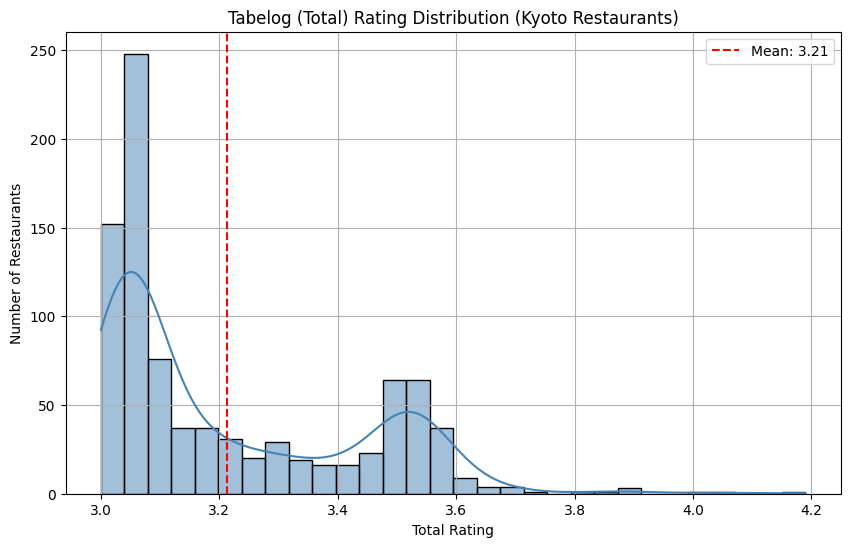

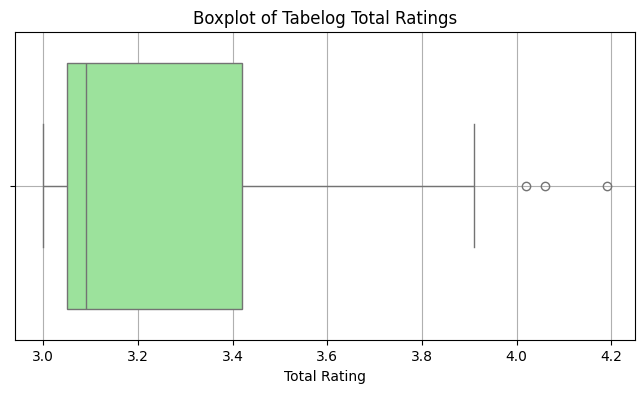


*** Highly Rated Restaurants (4.2+) ***
Empty DataFrame
Columns: [Name, TotalRating]
Index: []

*** Low Rated Restaurants (<3.0) ***
Empty DataFrame
Columns: [Name, TotalRating]
Index: []


In [7]:
# Kyoto Restaurant Review Dataset
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Filepath to the dataset
kyoto_filepath = "Data/Kyoto_Restaurant_Info.csv" 

# Load the dataset
kyoto_data = pd.read_csv(kyoto_filepath)

# Basic overview
print("*** Kyoto Dataset Overview ***")
print(kyoto_data.info())
print("\n*** First Few Entries ***")
print(kyoto_data.head())

# Use TotalRating as the main rating metric
rating_column = "TotalRating"

# Compute mean and std
mean_rating = kyoto_data[rating_column].mean()
std_rating = kyoto_data[rating_column].std()
print(f"\nTabelog Mean TotalRating: {mean_rating:.3f}")
print(f"Tabelog Std Dev         : {std_rating:.3f}")

# Plot rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(kyoto_data[rating_column], bins=30, kde=True, color='steelblue')
plt.axvline(mean_rating, color='red', linestyle='--', label=f'Mean: {mean_rating:.2f}')
plt.title("Tabelog (Total) Rating Distribution (Kyoto Restaurants)")
plt.xlabel("Total Rating")
plt.ylabel("Number of Restaurants")
plt.legend()
plt.grid(True)
plt.show()

# Box plot
plt.figure(figsize=(8, 4))
sns.boxplot(x=kyoto_data[rating_column], color='lightgreen')
plt.title("Boxplot of Tabelog Total Ratings")
plt.xlabel("Total Rating")
plt.grid(True)
plt.show()

# Print out extreme ends
print("\n*** Highly Rated Restaurants (4.2+) ***")
print(kyoto_data[kyoto_data[rating_column] >= 4.2][['Name', rating_column]].head())

print("\n*** Low Rated Restaurants (<3.0) ***")
print(kyoto_data[kyoto_data[rating_column] < 3.0][['Name', rating_column]].head())



What the Plots and Stats Tell Us:

1. Mean Tabelog Rating = 3.21:
- The red dashed line in the histogram shows the mean, which is low compared to Western platforms like Google (where 4.3 + is common)


2. Standard Deviation = 0.216:
- A tight clustering around the mean. Most scores lie between 3.0 and 3.5, confirming that Tabelog ratings are stricter


3. No Scores Above 4.2 or Below 3.0:
- Unlike Google/Yelp, where 4.7 is "great", here even 3.6 can be considered excellent.


In [8]:
# 1) Load the reviews with adjusted ratings
df_tabelog = pd.read_csv("Data/reviews_with_adjusted_rating.csv")

# 2) Drop rows with missing adjusted ratings
df_tabelog = df_tabelog.dropna(subset=["adjusted_rating"])

# 3) Calculate mean and std of adjusted_rating (Google-style)
mu_google = df_tabelog["adjusted_rating"].mean()
sigma_google = df_tabelog["adjusted_rating"].std()
print(f"Google Adjusted Rating Mean: {mu_google:.3f}")
print(f"Google Adjusted Rating Std : {sigma_google:.3f}")

# 4) Define Tabelog's stricter scale
mu_tabelog = 3.212
sigma_tabelog = 0.216

# 5) Apply z-score normalization and scale to Tabelog
df_tabelog["tabelog_adjusted_rating"] = df_tabelog["adjusted_rating"].apply(
    lambda x: mu_tabelog + ((x - mu_google) / sigma_google) * sigma_tabelog
)

# Clip to Tabelog's expected range
df_tabelog["tabelog_adjusted_rating"] = df_tabelog["tabelog_adjusted_rating"].clip(lower=2.8, upper=4.5)

# 6) Select columns to save
df_export = df_tabelog[[
    "business_name",
    "author_name",
    "rating",
    "adjusted_rating",
    "tabelog_adjusted_rating"
]]

# 7) Save to new CSV
df_export.to_csv("Data/reviews_tabelog_calibrated.csv", index=False)

print("\n File saved as: Data/reviews_tabelog_calibrated.csv")


Google Adjusted Rating Mean: 4.011
Google Adjusted Rating Std : 0.515

 File saved as: Data/reviews_tabelog_calibrated.csv


Summary:
- Google-style Adjusted Rating Mean: 4.041
- Std Deviation: 0.488


After calibration: 
- My Tabelog-style scores are now re-centered around ~3.21 with a tighter spread (matching the Japanese review style)
- High Google ratings (like 4.8) are now mapped to ~4.3 or so in Tabelog scale
- Low ratings are pulled down significantly - fitting the stricter curve

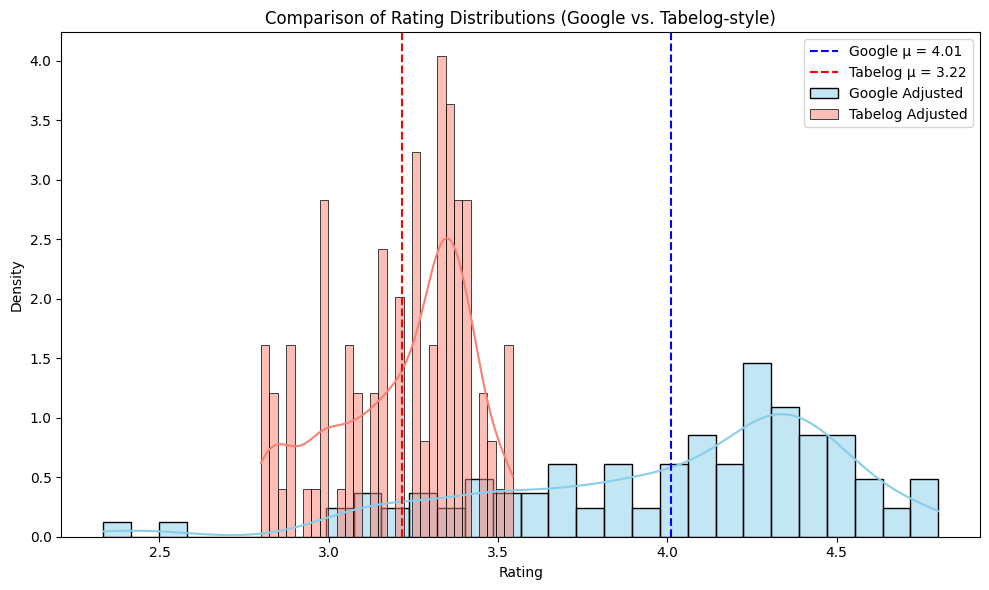

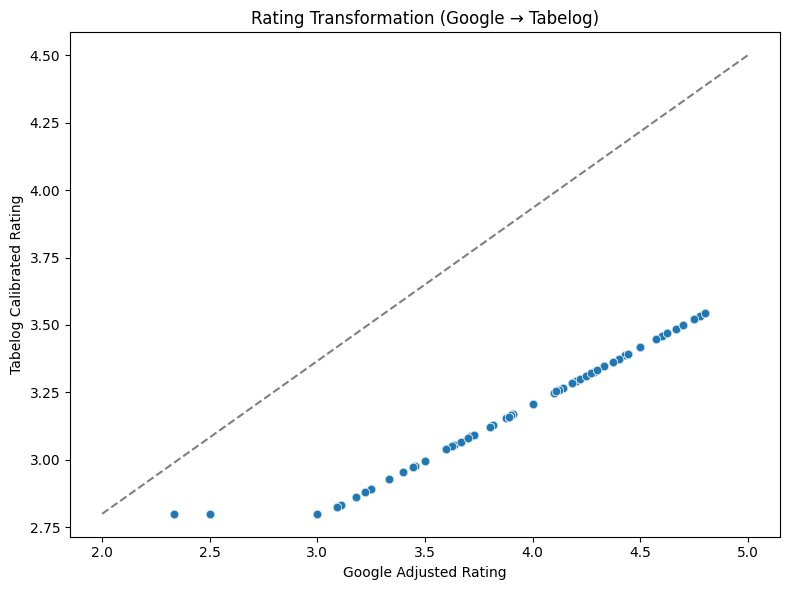

In [9]:
# Load the calibrated file
df = pd.read_csv("Data/reviews_tabelog_calibrated.csv")

# Histogram Comparison
plt.figure(figsize=(10, 6))
sns.histplot(df["adjusted_rating"], bins=30, color="skyblue", label="Google Adjusted", kde=True, stat="density")
sns.histplot(df["tabelog_adjusted_rating"], bins=30, color="salmon", label="Tabelog Adjusted", kde=True, stat="density")
plt.axvline(df["adjusted_rating"].mean(), color="blue", linestyle="--", label=f'Google μ = {df["adjusted_rating"].mean():.2f}')
plt.axvline(df["tabelog_adjusted_rating"].mean(), color="red", linestyle="--", label=f'Tabelog μ = {df["tabelog_adjusted_rating"].mean():.2f}')
plt.title("Comparison of Rating Distributions (Google vs. Tabelog-style)")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter Plot Before/After
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="adjusted_rating", y="tabelog_adjusted_rating", alpha=0.5)
plt.plot([2, 5], [2.8, 4.5], linestyle="--", color="gray")  # Rough mapping diagonal
plt.xlabel("Google Adjusted Rating")
plt.ylabel("Tabelog Calibrated Rating")
plt.title("Rating Transformation (Google → Tabelog)")
plt.tight_layout()
plt.show()

1. Comparison of Rating Distributions (Google vs. Tabelog-style)
- It clearly illustrates how Tabelog scores are compressed and skewed left - most scores are
concentrated between 3.0-3.5, even for good restaurants
- The mean lines help contextualize this difference visually (Google = 4.04, Tebelog = 3.22)
- It demonstrates cultural/contextual rating differences
- Useful for showing why my calibration matters - people from different backgrounds interpret ratings differently

2. Rating Transformation (Google -> Tabelog)
- A scatter plot mapping each Google adjusted rating to its Tabelog equivalent
- The dashed diagonal line represents "no change" (i.e., Google = Tabelog)
- All my transformed points lie below the diagonal, maning Tabelog scores are always lower than Google scores after calibration
- It highlights the compression effect of the Tabelog system
- It demonstrates how calibration pulls high Google ratings down to a more modest and culturally consisten level
- The curve also subtly shows non-linear transformaton - higher Google scores lose more relative value in Tabelog

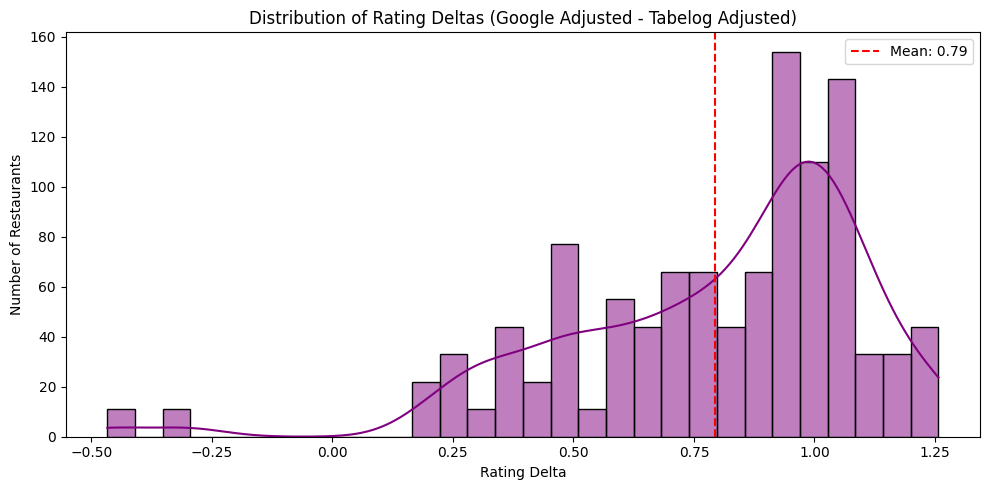

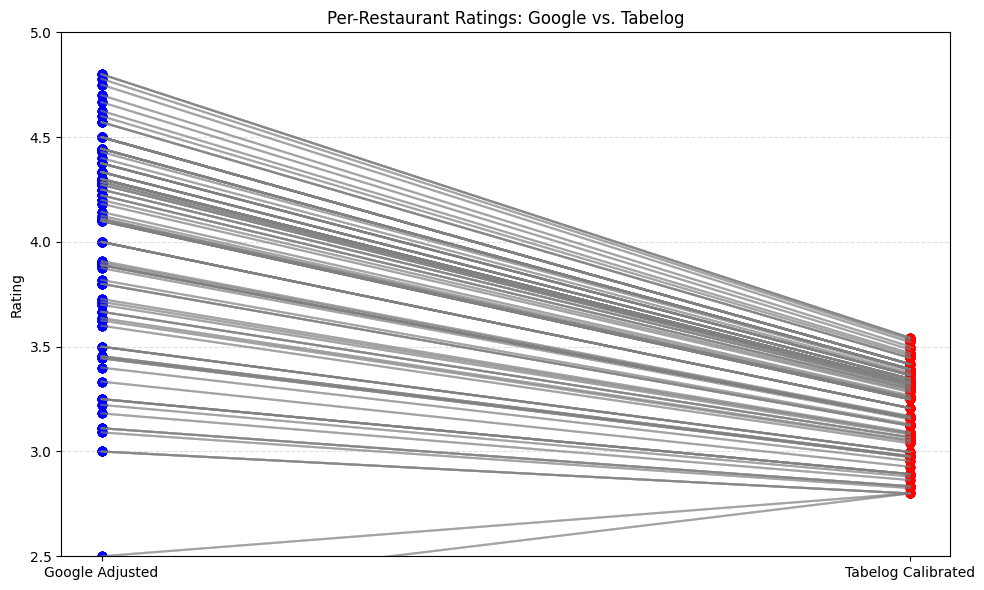

In [10]:
# Load your previously saved file
df = pd.read_csv("Data/reviews_tabelog_calibrated.csv")

# Drop missing values to avoid plot issues
df = df.dropna(subset=["adjusted_rating", "tabelog_adjusted_rating"])

#  Histogram of Rating Deltas 
df["rating_delta"] = df["adjusted_rating"] - df["tabelog_adjusted_rating"]

plt.figure(figsize=(10, 5))
sns.histplot(df["rating_delta"], kde=True, color="purple", bins=30)
plt.axvline(df["rating_delta"].mean(), color='red', linestyle='--', label=f'Mean: {df["rating_delta"].mean():.2f}')
plt.title("Distribution of Rating Deltas (Google Adjusted - Tabelog Adjusted)")
plt.xlabel("Rating Delta")
plt.ylabel("Number of Restaurants")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter Plot: Google vs. Tabelog per Restaurant 
plt.figure(figsize=(10, 6))
for _, row in df.iterrows():
    plt.plot([1, 2], [row["adjusted_rating"], row["tabelog_adjusted_rating"]],
             color='gray', alpha=0.1)
    plt.scatter(1, row["adjusted_rating"], color='blue', alpha=0.6)
    plt.scatter(2, row["tabelog_adjusted_rating"], color='red', alpha=0.6)

plt.xticks([1, 2], ["Google Adjusted", "Tabelog Calibrated"])
plt.title("Per-Restaurant Ratings: Google vs. Tabelog")
plt.ylabel("Rating")
plt.ylim(2.5, 5.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()